# Telemetry Compaction

Telemetry dimensionality reduction / compaction includes identification of all redundant attributes through correlation analysis and removing them. Since scale of each attribute is varying a lot, we apply log transformation to normalize all the values. We validate that accuracy doesn’t change due to telemetry compaction.

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import skew
from DBScan import HDB,modelling

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from sklearn.model_selection import train_test_split
from preprocessing import preprocess
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
#Preprocessing Data 

class preprocess(object):
    
    def __init__(self,data):
        self.data = data
    
    #drop constant parameters
    def variation(self):
        return self.data.loc[:,self.data.apply(pd.Series.nunique) != 1]
    
    #drop categorical parameters
    def drop_categorical(self):
        dtype = self.data.dtypes
        col = list(dtype[(dtype=='float64') | (dtype=='int64')].index)
        return self.data[col]
    
    def numerical_data(self):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        return self.data.select_dtypes(include=numerics)
    
    #drop observations having nan values
    def drop_na(self):
        return self.data.dropna(axis=0)

    #chek and drop high correlation parameters
    def correlation(self):
        corr = self.data.corr().abs()
        corr = pd.DataFrame(np.tril(corr, k =-1), columns = self.data.columns)
        drop = [column for column in corr.columns if any(corr[column] > 0.95)]
        return self.data.drop(drop,axis=1)
    
    #check skewness of all parameters and use log transform if half of parameters are enough skewd
    #otherwise use standardization
    def Log_transform(self):
        skew_df=[abs(float(x)) for x in skew(self.data)]
        count=0
        for i in skew_df:
            if i>2:
                count+=1
        if count*2>len(skew_df):
            self.data=self.data.applymap(lambda x: np.log(x+1))
        else:
            self.data = self.normalize()
            
        return self.data
    
    #normalize the data
    def normalize(self):
        upper = self.data.max()
        lower = self.data.min()
        return (self.data - lower)/(upper-lower)  
    
    #remove time stamp
    def timeStamp(self):
        try:
            self.data.time = self.data.time/1000000000
            self.data.time = pd.to_datetime(self.data.time, unit = 's')
        except:
            pass
        return self.data
    
    #check_variable('trafic, ')
    def check_parameter(self):
        if 'traffic' in self.data.columns:
            try:
                self.data.loc[self.data['traffice'] == '', 'traffic'] = 'Normal'
                self.data.loc[self.data.isna()] == 'Normal'
            except:
                pass
            
        if 'stimuli' in self.data.columns:
            try:
                self.data.loc[self.data['stimuli'] == '', 'stimuli'] = 'Normal'
                self.data.loc[self.data.isna()] == 'Normal'
            except:
                pass
        return self.data
     
    def process(self):
        if 'Anomaly' in self.data.columns:
            anomaly = self.data.Anomaly
        time  = self.data.time
        self.data = self.data.drop(['time'], axis = 1)
        self.data = self.check_parameter()
        self.data = self.numerical_data()
        self.data = self.drop_na()
        self.data = self.variation()
        self.data = self.correlation()
        self.data = self.Log_transform()
        self.data = self.data.abs()
        self.data['time'] = time
        self.data = self.timeStamp()        
        try:
            self.data['Anomaly'] = anomaly 
        except :
            pass
        return self.data


#Random Forest algorithm to test f1-score on orginal and compacted Data

def validate(data):
    '''
    Ten-fold cross-validation with stratified sampling.
    '''
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    y=data['Anomaly']
    X = data.drop(['Anomaly', 'time'], axis =1)
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=2,   random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
   
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    #print('Accuracy', np.mean(accuracy_scores))
    #print('Precision', np.mean(precision_scores))
    #print('Recall', np.mean(recall_scores))
    #print('F1-measure', np.mean(f1_scores)) 
    return np.mean(f1_scores)

   Original_size  Compacted_size
0            133              14
   Compacted f1-Score  Original f1-Score
0            0.924224           0.922408


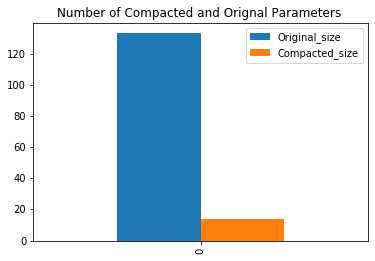

In [4]:
#orignal data/Loading Data
path = '../netfilter_anomally.csv'
df = pd.read_csv(path)

#compaction data
db = preprocess(df)
pre_df = db.process()
pre_df = HDB(pre_df)
size_df = pd.DataFrame([[df.shape[1], pre_df.shape[1]]], columns = ["Original_size", "Compacted_size"])

#size plot of compaction and orignal data
print(size_df)
size_df.plot.bar(title = "Number of Compacted and Orignal Parameters ")

#Anomaly detection on Original Data
df['Anomaly'] = pre_df['Anomaly']
if 'name' in df.columns:
    df = df.drop(['name'], axis = 1)

nc_score = validate(df)

#Anomaly detection on Compacted Data
c_score = validate(pre_df)
f1_df = pd.DataFrame([[c_score, nc_score]], columns = ["Compacted f1-Score","Original f1-Score"])
print(f1_df)

# DBScan for Anomaly Detection

In [5]:
#DBScan for anomaly detection
def dbFun(df):
    time = df.time
    df = df.drop('time', axis = 1)
    db = DBSCAN(eps=0.01, min_samples=38).fit(df)
    df['Anomaly'] = db.labels_
    df['Anomaly'] = df['Anomaly'].apply(lambda x : 1 if x == -1 else 0)
    df['time'] = time
    return df


def predict(df):
    d = preprocess(df)
    pre_df = d.process()
    del d
   
    label_df = dbFun(pre_df)
    label_df.index = range(len(label_df))
    return label_df

#plot for anomulous point 
def plot(df):
    df.index = df.time
    plt.figure() 
    plt.xlabel("Time") 
    plt.ylabel("Throughput") 
    plt.gcf().autofmt_xdate()
    df['throughput'].plot.line() 
    anomaly = df[df['Anomaly'] == 1]
    plt.plot(anomaly.iloc[:]['time'],anomaly.iloc[:]['Anomaly'],"ro") 
    plt.show()
    
#elbow plot for chossing epsilon
def eps(df):
    df = df[['throughput']]
    min_samples = 50
    k = min_samples if min_samples>2 else 2
    nbrs = NearestNeighbors(n_neighbors = k).fit(df)
    distances, indces = nbrs.kneighbors(df)

    df['knn'] = distances[:,-1]
    df.sort_values('knn', ascending = False).reset_index()[['knn']].plot()
    return df

   throughput  Anomaly                time
0    0.035966        0 2019-07-17 13:50:58
1    0.923838        0 2019-07-17 13:50:49
2    0.380375        0 2019-07-17 13:50:38
3    0.000040        0 2019-07-17 13:50:29
4    0.226944        0 2019-07-17 13:50:19


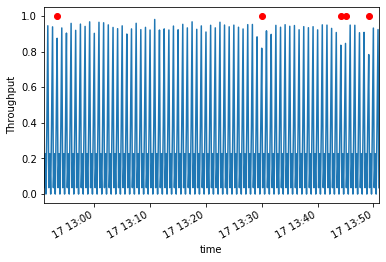

In [6]:
path = '../kpi_anomally.csv'
data = pd.read_csv(path)
df = predict(data)
print(df.head())
plot(df.loc[0:360,:])

# AutoEncoder for Anomaly Prediction

In [25]:
def AutoEncoderModelling(X, X_train):
    fname = 'AEModel.h5'
    model = Sequential()
    model.add(Dense(25, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(X.shape[1])) # Multiple output neurons
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train,X_train,callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                                  ModelCheckpoint(filepath = fname, monitor='val_loss', 
                                    save_best_only=True)],verbose=1,epochs=10)
    return model

def train_test(df):
    X_train, X_test = train_test_split(df, test_size=0.25, random_state=42)
    model = AutoEncoderModelling(df, X_train)
    pred = model.predict(X_test)
    X_pred = pd.DataFrame(pred, columns = X_test.columns, index = X_test.index)
    score1 = np.sqrt(metrics.mean_squared_error(pred,X_test))
    
    print("Score (RMSE): {}".format(score1))
    #scored = pd.DataFrame(np.mean(score1), columns = ['loss'])
    error = (X_test - X_pred).mean(axis = 1)
    plt.title('Average Error')
    sns.distplot(error, bins = 20, kde = True, color = 'blue', label = 'Average Error')
    plt.show()
    
    threshold = error.mean() + 3*error.std()
    X_test['Anomaly'] = error.apply(lambda x : 1 if x > threshold else 0)
    return X_test


Epoch 1/10
2611/2611 [==============================] - 1s 353us/sample - loss: 132.6145
Epoch 2/10
2611/2611 [==============================] - 0s 74us/sample - loss: 23.7324
Epoch 3/10
2611/2611 [==============================] - 0s 71us/sample - loss: 9.3575
Epoch 4/10
2611/2611 [==============================] - 0s 81us/sample - loss: 7.4910
Epoch 5/10
2611/2611 [==============================] - 0s 64us/sample - loss: 5.5068
Epoch 6/10
2611/2611 [==============================] - 0s 79us/sample - loss: 4.7108
Epoch 7/10
2611/2611 [==============================] - 0s 92us/sample - loss: 3.9353
Epoch 8/10
2611/2611 [==============================] - 0s 93us/sample - loss: 3.4562
Epoch 9/10
2611/2611 [==============================] - 0s 108us/sample - loss: 2.9707
Epoch 10/10
2611/2611 [==============================] - 0s 124us/sample - loss: 3.0386s - loss: 
Score (RMSE): 1.8950883726796115
time
2019-07-17 04:05:04    1.358414
2019-07-17 07:48:54    1.362386
2019-07-17 07:18:14  

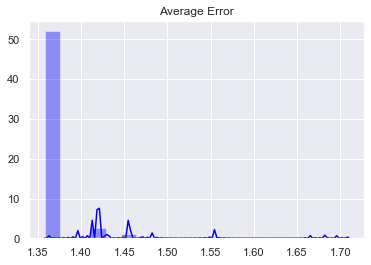

                     cpu_1_cpu_nice  memory_slab_recl  memory_slab_unrecl  \
time                                                                        
2019-07-17 12:39:13        9.455637         19.420465           17.263359   
2019-07-17 13:43:33        9.455637         19.420420           17.268688   
2019-07-17 13:30:53        9.455637         19.420480           17.264271   
2019-07-17 13:29:23        9.455637         19.420480           17.263359   
2019-07-17 12:40:43        9.455637         19.420480           17.263359   
2019-07-17 13:44:03        9.455637         19.420420           17.263490   
2019-07-17 07:54:34        9.455637         19.420480           17.267650   
2019-07-17 13:31:43        9.455637         19.420480           17.264141   
2019-07-17 07:55:44        9.455637         19.420480           17.268558   
2019-07-17 13:45:13        9.455637         19.420420           17.263229   
2019-07-17 13:30:23        9.455637         19.420480           17.263229   

In [26]:
df = train_test(pre_df.drop('time', axis = 1))
print(df[df['Anomaly'] == 1])

# Cross Layer Fault Signs

These are the combination of attributes that causes anomalous behaviour in the system. Once the anomaly is predicted, we consider the points where there are consecutive number of anomalous records occur (configurable, currently 2 consecutive). Next, we find out the rate of change of all the attribute values with their corresponding previous values and observe the significantly changed attributes. These attributes are marked as fault signs and can be given additional focus to avoid future anomalies. When fault signatures of each layer are looked at, SMEs can decipher bottleneck patterns between layers (not covered in this test).

In [16]:
#class to find fault sign for each vnf 
class Faultsign(object):
    def __init__(self, data):
        self.Time = data.time
        self.cluster = data.Anomaly
        self.df = data.drop(['time' , 'Anomaly'], axis =1)    
    
    def fault_df(self, vnf_name):
        df = self.df
        df['Anomaly'] = self.cluster
        index_ = df[df['Anomaly'] == 1].index
        index = []
        for ind in index_:
            if ind +1 in index_:
                index = index + [ind-1, ind, ind+1]
                
        df = df.iloc[index][:]

        df = df.diff()
        df = df.drop(['Anomaly'], axis = 1)
        fault = []
        df.columns = vnf_name + '_' + df.columns
        for i in range(len(df)):
            param = df.iloc[i].sort_values(ascending = False)
            pos_param = param[param > 0]
            if len(pos_param) > 0:
                fault.append(" , ".join( list(pos_param.head().index) ))            
          
        fault_df = pd.DataFrame(fault,columns = ['FaultSign'])    
        return fault_df

#Plugin and faultsigns that are repeating 
def cross_layer_fault(df, var_list, vnf_list):    
     for var in var_list:
         df[var] = df['FaultSign'].str.count(var)
     
     plugin = df.drop('FaultSign', axis = 1).idxmax(axis =1) 
     df = df[['FaultSign']]
     for vnf in vnf_list:
         df[vnf] =  df['FaultSign'].str.count(vnf)
     df['vnf'] = df.drop('FaultSign', axis = 1).idxmax(axis =1)
     df['plugin'] = plugin
     df = df[['FaultSign', 'vnf' , 'plugin' ]]
     return df
     
#merge all vnf based on anomaly and time
def cross_layer_table(dfs, vnf):
    data = pd.DataFrame()
    length = []
    for i in range(len(dfs)):
        dfs[i] = dfs[i][['time', 'Anomaly']]
        dfs[i].columns  = vnf[i] + '_'+ dfs[i].columns
        length.append(len(dfs[i]))
    
    min_len = min(length)
    for i in range(len(dfs)):
        dfs[i] = dfs[i].iloc[:min_len][:]
        data = pd.concat([data, dfs[i]], axis = 1)
    df = cross_layer_anomaly(data).dropna()
    return df

#Anomaly priority based (high/low) dataframe 
def cross_layer_anomaly(df):
    names = [name for name in df.columns if 'Anomaly' in name]
    df['priority'] = df[names].sum(axis = 1)
    df['class'] =  df['priority'].apply(lambda x : 'High' if x>=2 else 'Low')
    time_names = [name for name in df.columns if 'time' in name]
    time = df.iloc[:][time_names[0]]
    df = df.drop(time_names, axis = 1)
    df['time'] = time
    return df        

In [17]:
#Loading data for all vnf's
path = "c:/temp/vnf/Label"
files = os.listdir(path)
pre_dfs = []
vnf = []
dfs = pd.DataFrame()
for file in files:
    vnf_name = file.split('_')[0]
    print("File " + file + " Starts")            
    df = pd.read_csv(path + '/'+ file)
    db = preprocess(df) #Preprocssing
    pre_df = db.process()
    vnf.append(vnf_name)
    pre_dfs.append(pre_df)

    f = Faultsign(pre_df)  #Fault Signs for each vnf
    fault = f.fault_df(vnf_name)
    if len(dfs) == 0: 
        dfs = fault
    else:
        l = min(len(dfs), len(fault))
        dfs = dfs.add(fault, axis = 0).head(l)     #merge faultSigns together       
    
var_list = ['memory', 'cpu', 'interface', 'processes']
cross_layer_fault_df = cross_layer_fault(dfs, var_list, vnf)
cross_layer_anomaly_df = cross_layer_table(pre_dfs, vnf)
print(cross_layer_anomaly_df[cross_layer_anomaly_df['class'] == 'High'])
print(cross_layer_fault_df)

File kpi_anomally.csv Starts
File netfilter_anomally.csv Starts
File shorewell_anomally.csv Starts
File snort_sfc_anomally.csv Starts
      kpi_Anomaly  netfilter_Anomaly  shorewell_Anomaly  snort_Anomaly  \
2             0.0                0.0                1.0            1.0   
3             0.0                0.0                1.0            1.0   
4             0.0                0.0                1.0            1.0   
27            0.0                1.0                1.0            0.0   
61            0.0                0.0                1.0            1.0   
132           0.0                0.0                1.0            1.0   
402           0.0                1.0                0.0            1.0   
411           1.0                0.0                0.0            1.0   
456           1.0                1.0                0.0            0.0   
1066          1.0                0.0                1.0            0.0   
1073          0.0                0.0                

# SpyderChart

In [18]:
#resampling data on 1 minute based and taking last 5 average
def mean(df):
    return df.resample('1 min').mean().tail(5)

#resampling data on 1 minute based and taking minimum
def Min(df):    
    return df.resample('1 min').min().head(1)

#resampling data on 1 minute based and taking maximum
def Max(df):
    return df.resample('1 min').max().tail(1)

#binding min, max and mean together to plot radar chart
def bindData(df):
    min_ = Min(df)
    max_ = Max(df)
    mean_ = mean(df)
    for i in range(len(mean_)):
        dfs = min_.append(max_).append(mean_.iloc[i])
        print(i)
        RadarChart(dfs)
        
#plot Radar Chart
def RadarChart(df):
    df.index = range(len(df))
    labels=df.drop('time', axis = 1).columns.values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False) # Set the angle
    angles=np.concatenate((angles,[angles[0]]))  # Closed
    fig=plt.figure()
    sns.set()
    col = ['r', 'b', 'y']
    for i in range(len(df)):
        stats=df.loc[i,labels].values  
        # close the plot
        stats=np.concatenate((stats,[stats[0]]))  # Closed
        
        ax = fig.add_subplot(111, polar=True)   # Set polar axis

        ax.plot(angles, stats, 'o-', linewidth=1)  # Draw the plot (or the frame on the radar chart)
        ax.fill(angles, stats,col[i], alpha=0.25)  #Fulfill the area
        ax.set_thetagrids(angles * 180/np.pi, labels)  # Set the label for each axis
        #ax.set_title([df.loc[386,"Name"]])  # Set the pokemon's name as the title
        #ax.set_rlim(0,250)
        ax.grid(True)
    plt.show()

0


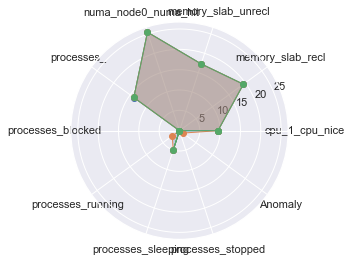

1


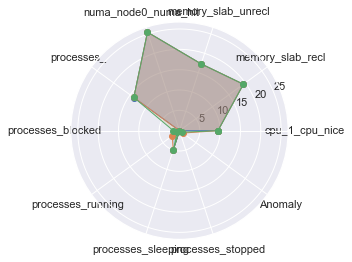

2


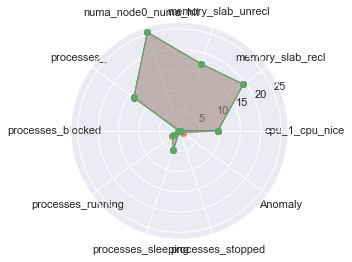

3


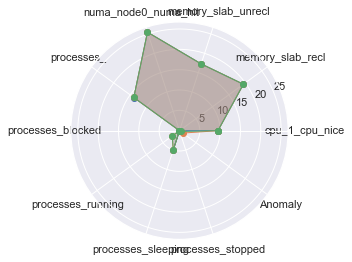

4


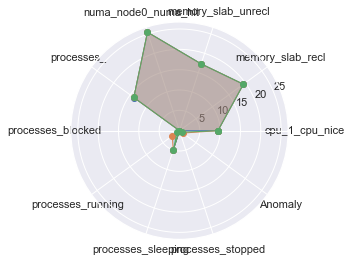

In [19]:
pre_df.index = pre_df.time
bindData(pre_df)